In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
import pandas as pd
import tensorflow as tf
from sklearn.datasets import load_files
from glob import glob
import numpy as np
from keras.utils import np_utils
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(data['target'], 133)
    return dog_files, dog_targets

### Dog dataset

In [4]:
test_files, test_targets = load_dataset('dogImages/test/')
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
total_img = len(test_files) + len(train_files) + len(valid_files)

print('Dog categoris: {}'.format(len(test_targets[0])))
print('Dog images: {}'.format(total_img))

print('Training images: {}'.format(len(train_files)))
print('Testing images: {}'.format(len(test_files)))
print('Validation images: {}'.format(len(valid_files)))


Dog categoris: 133
Dog images: 8351
Training images: 6680
Testing images: 836
Validation images: 835


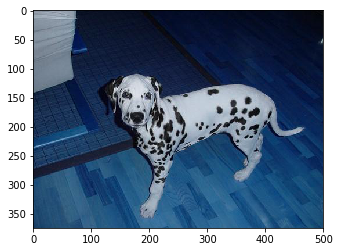

In [5]:
plt.imshow(cv2.imread(test_files[0]))
plt.show()

### Human Dataset

In [6]:
h_data = np.array(glob('lfw/*/*'))
print('Human images: {}'.format(np.shape(h_data)[0]))

Human images: 13234


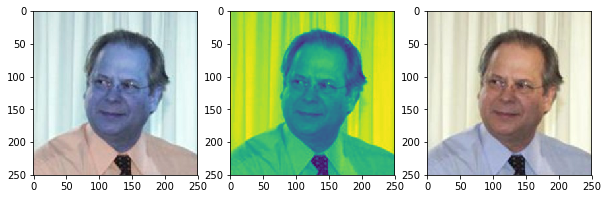

In [7]:
img = cv2.imread(h_data[1])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(gray)
plt.subplot(133)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

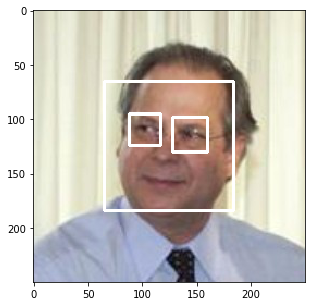

In [8]:
face_cas = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
eye_cas = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')
faces = face_cas.detectMultiScale(gray)
eyes = eye_cas.detectMultiScale(gray)
for x, y, w, h in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)
    
    for x, y, w, h in eyes:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
def verify_face_exist(file):
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return len(face_cas.detectMultiScale(gray)) > 0

In [ ]:
undetected_human_face = sum([1 for i in h_data if not verify_face_exist(i)])
undetected_dog_face = sum([1 for i in train_files if not verify_face_exist(i)])
precentage_human = undetected_human_face / len(h_data)
precentage_dog = undetected_dog_face / len(train_files)
print('Missing faces\nHuman: {}({}%) Dog: {}({}%)'.format(undetected_human_face, precentage_human,
                                                          undetected_dog_face, precentage_dog))

### Keras

In [2]:
from keras.applications.resnet50 import ResNet50
res_net = ResNet50(weights='imagenet')

In [10]:
np.shape(cv2.imread(train_files[0]))

(427, 640, 3)

In [11]:
from keras.preprocessing import image
def path_to_tensor(path):
    img = image.load_img(path, target_size=[224, 224])
    img = image.img_to_array(img, 'channels_last')
    return np.expand_dims(img, axis=0)

In [12]:
np.shape(path_to_tensor(train_files[0]))

(1, 224, 224, 3)

In [14]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y = np.array([[0], [1], [1], [0]], dtype=np.float32)
print('X: {}, y: {}'.format(np.shape(X), np.shape(y)))

X: (4, 2), y: (4, 1)


In [15]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1]))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('softmax'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics= ["accuracy"])
model.summary()
model.fit(X, y, epochs=1000, verbose=0)
model.evaluate(X, y)[-1]
#model.predict_proba(X)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 24        
_________________________________________________________________
activation_50 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
_________________________________________________________________
activation_51 (Activation)   (None, 1)                 0         
Total params: 33.0
Trainable params: 33.0
Non-trainable params: 0.0
_________________________________________________________________
4/4 [==============================] - 0s


0.5

### Mini_Project Student_Admissions

In [50]:
df = pd.read_csv('../aind2-dl/student_data.csv')
df.head()

,admit,gre,gpa,rank
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


Plotting GRE and GPA scores based on being admitted (cyan) or rejected (red)

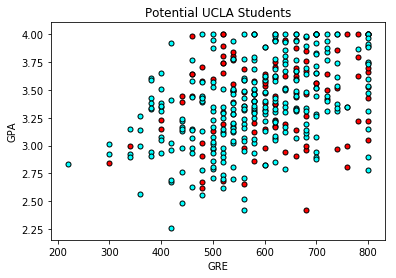

In [81]:
def plot_df(df):
    admitted = df[df['admit'] == 1]
    rejected = df[df['admit'] == 0]
    plt.scatter(admitted['gre'], admitted['gpa'], s=25, color='red', edgecolor='k')
    plt.scatter(rejected['gre'], rejected['gpa'], s=25, color='cyan', edgecolor='k')
    plt.xlabel('GRE')
    plt.ylabel('GPA')

plot_df(df)
plt.title('Potential UCLA Students')
plt.show()

Seperate the plot by ranks

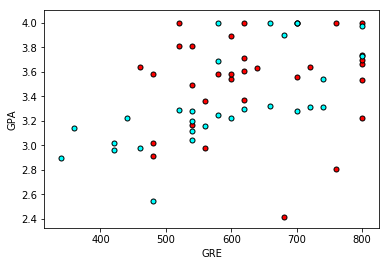

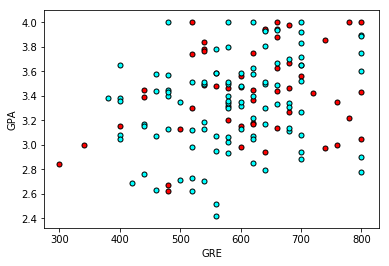

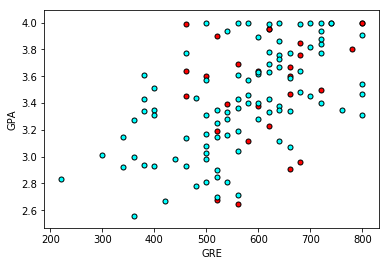

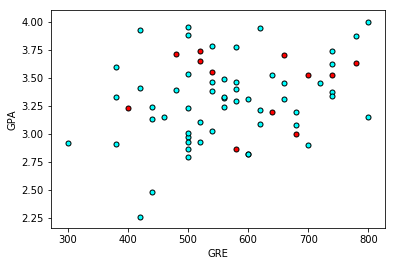

In [84]:
rank_1 = df[df['rank'] == 1]
rank_2 = df[df['rank'] == 2]
rank_3 = df[df['rank'] == 3]
rank_4 = df[df['rank'] == 4]
plot_df(rank_1)
plt.show()
plot_df(rank_2)
plt.show()
plot_df(rank_3)
plt.show()
plot_df(rank_4)
plt.show()

Preprocess the data, by normalizing the data and get_dummies

In [93]:
def normalize(df, cols):
    for i in cols:
        df[i] = df[i]/df[i].max()
    return df

In [143]:
df = normalize(df, ['gre', 'gpa'])
df = pd.get_dummies(df, columns=['rank'])
assert df['gre'].max() == 1
assert df['gpa'].max() == 1

One hot incode the admit colum

In [144]:
X = np.array(df.drop('admit', axis=1))
y = np_utils.to_categorical(np.array(df['admit']))
assert X.shape == (len(df), len(df.columns)-1)
assert y.shape == (len(df), 2)

In [146]:
X_train, X_test, y_train, y_test = X[50:], X[:50], y[50:], y[:50]
print('X_train: {}'.format(X_train.shape))
X[:10]

X_train: (350, 6)


array([[ 0.475 ,  0.9025,  0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.825 ,  0.9175,  0.    ,  0.    ,  1.    ,  0.    ],
       [ 1.    ,  1.    ,  1.    ,  0.    ,  0.    ,  0.    ],
       [ 0.8   ,  0.7975,  0.    ,  0.    ,  0.    ,  1.    ],
       [ 0.65  ,  0.7325,  0.    ,  0.    ,  0.    ,  1.    ],
       [ 0.95  ,  0.75  ,  0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.7   ,  0.745 ,  1.    ,  0.    ,  0.    ,  0.    ],
       [ 0.5   ,  0.77  ,  0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.675 ,  0.8475,  0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.875 ,  0.98  ,  0.    ,  1.    ,  0.    ,  0.    ]])

In [206]:
model = Sequential()
model.add(Dense(256, input_dim=X.shape[-1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y.shape[-1], activation='sigmoid'))
model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metric=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 256)               1792      
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_43 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 2)                 130       
Total para

In [207]:
model.fit(X_train, y_train, epochs=200, batch_size=50, verbose=False)
model.evaluate(X_test, y_test)

/home/ksooklall/anaconda3/envs/aind-dog/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


32/50 [==================>...........] - ETA: 0s

0.72991064548492435

## IMDB Movie Data

Load data from keras

In [35]:
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

### Preprocessing

In [36]:
np_y_train, np_y_test  = np.eye(max(y_train)+1)[y_train], np.eye(max(y_test)+1)[y_test]
assert np_y_train.shape == (25000, 2) == np_y_test.shape == (25000, 2)

In [37]:
k_y_train, k_y_test = np_utils.to_categorical(y_train, 2), np_utils.to_categorical(y_test, 2)
assert k_y_train.shape == (25000, 2) == k_y_test.shape == (25000, 2)

np.testing.assert_array_equal(np_y_train, k_y_train)
np.testing.assert_array_equal(np_y_test, k_y_test)